In [102]:
%matplotlib inline

In [135]:
def missing_data_finder(input_file, output_file_path, blacklisted_tags_cutoff=100):
    
    '''
    
    This function will count the number of tags that droupout in all samples
    in the specified VCF. It will output the data and simple bar plots of both 
    the number of dropouts per sample, and the number of dropouts per tag. It will also 
    output a file called blacklist.txt containing locus IDs which can be used to remove 
    these loci from subsequent runs of the stacks populations module.
    
        input_file              -  full path to vcf
        output_file_path        -  path to output data, plots and blacklist to
        blacklisted_tags_cutoff -  number of 'worst' tags to blacklist
        
    '''
    
    
    import sys
    import vcf 
    import numpy as np
    import matplotlib.pyplot as plt 
    from collections import Counter
    from operator import itemgetter


    ## Alter the allele depth header line - which doesn't seem to be compatible between Stacks and PyVCF. 
    
    myvcf = open(input_file, 'r').readlines()
    alteredvcfpath = "%s%s" %(input_file, ".altered")
    alteredvcf = open(alteredvcfpath, 'w')
    
    for line in myvcf:
        if "Allele Depth" not in line:
            alteredvcf.write(line)
        elif "Allele Depth" in line:
            line = '##FORMAT=<ID=AD,Number=.,Type=Integer,Description="Allele Depth">\n'
            alteredvcf.write(line)
    alteredvcf.close()
    
    ## Now open altered file and continue
    
    alteredvcf = open(alteredvcfpath, 'r')
    
    vcf_reader = vcf.Reader(alteredvcf) 
    record = next(vcf_reader)
    
    samples = vcf_reader.samples ## get all the samples in the file

    ## Count the missing data --------------------------------------------------------------------------------------------------------
    
    missing_data_count = {}
    missing_data_tags = {}
    
    for record in vcf.Reader(open(alteredvcfpath, 'r')): 
        for sample in samples: ## for each sample
            if sample not in missing_data_count:
                missing_data_count[sample] = 0
            
            if record.ID not in missing_data_tags:
                missing_data_tags[record.ID] = 0
            
            if record.genotype(sample)['GT'] == None: ## If the current samples genotype for this record is missing ('./.'), count it with no_genotype_counter
                missing_data_count[sample] += 1
                missing_data_tags[record.ID] += 1

    
    ######### TAG DROPOUTS PER SAMPLE ######## -------------------------------------------------------------------------------------------
    
    sorted_tags_per_sample = sorted(missing_data_count.items(), key=itemgetter(1), reverse=True) ## write file from this sorted tags list
    
    ## Print tag dropouts per sample to file
    f = open(output_file_path+'/Tag_dropouts_per_sample.txt', 'w')
    f.write('sample\t#_missing_loci\n')
    for sample in sorted_tags_per_sample:
        f.write("%s\t%s\n" % (sorted_tags_per_sample[0], sorted_tags_per_sample[1]))
    f.close()
    

    
    ######### TAG DROPOUTS PER SAMPLE ######## -------------------------------------------------------------------------------------------
    
    x = []
    y = []
    xlabs = []
    counter = 1

    plt.figure(figsize=(70,50))

    for i, j in sorted_tags_per_sample:
        xlabs.append(i)        
        x.append(counter)
        y.append(int(j))
        counter += 1

    ## Plot the per-tag droupouts
    plt.bar(x,y, edgecolor = "none",align="center")
    plt.yticks(range(0,max(y),100), fontsize = 30)
    plt.xticks(x, xlabs, fontsize = 30, rotation = "vertical")
    plt.ylabel("Number of dropouts", fontsize = 30)
    plt.xlabel("Sample", fontsize = 30)
    plt.axhline(np.mean(y), linewidth=4, color='r')
    plt.title("Tag dropouts per sample", fontsize = 40)

    plt.tight_layout()
    plt.savefig("%s/Tag_dropouts_per_sample.pdf" % output_file_path)
    plt.show()
    plt.close()
    
    
    ######### TAG DROPOUTS PER TAG ######## -------------------------------------------------------------------------------------------
    
    sorted_tags = sorted(missing_data_tags.items(), key=itemgetter(1), reverse=True)
    
    x = []
    y = []
    xlabs = []
    blacklisted = []

    cut_off = blacklisted_tags_cutoff
    counter = 1
    plt.figure(figsize=(70,50))

    for i, j in sorted_tags:
        xlabs.append(i)
        x.append(counter)
        y.append(int(j))
        if counter <= blacklisted_tags_cutoff:
            blacklisted.append(j) ## write this to file
        counter += 1

    xarray = np.asarray(x)
    yarray = np.asarray(y)

    mask1 = xarray < cut_off
    mask2 = xarray >= cut_off

    ## write per-tag droupout data to file

    tag_drop_outs = open("%s/Tag_dropouts_per_tag.txt" % output_file_path, 'w')
    tag_drop_outs.write("TagID\tNumber_of_dropouts\n")

    for tag in sorted_tags:
        tag_drop_outs.write("%s\t%s\n" % (tag[0], tag[1]))
    tag_drop_outs.close()
    
    ## Write the blacklist file
    
    blacklist = open(output_file_path+'/blacklist.txt', 'w')
    for tag_ID in set(blacklisted):
        blacklist.write("%s\n" % (tag_ID))
    blacklist.close()

    ## Plot the per-tag droupouts
    plt.bar(xarray[mask1],yarray[mask1], edgecolor = "none")
    plt.bar(xarray[mask2],yarray[mask2], color = "grey", edgecolor = "none")
    plt.yticks(range(0,max(y),50), fontsize = 30)
    plt.xticks(range(0,max(x),100), fontsize = 30, rotation = "vertical")
    plt.ylabel("Number of dropouts", fontsize = 30)
    plt.xlabel("Tag", fontsize = 30)
    plt.axhline(np.mean(yarray), linewidth=4, color='r')
    plt.title("Tag dropouts per tag", fontsize = 40)

    #plt.tight_layout()
    
    plt.savefig("%s/Tag_dropouts_per_tag.pdf" % output_file_path)
    plt.show()
    plt.close()
    
    print 'Outputs written to:'
    print "%s/Tag_dropouts_per_sample.txt" % output_file_path
    print "%s/Tag_dropouts_per_tag.txt" % output_file_path
    print "%s/Tag_dropouts_per_sample.pdf" % output_file_path
    print "%s/Tag_dropouts_per_tag.pdf" % output_file_path
    print "%s/blacklist.txt" % output_file_path
    
    return missing_data_count


def missing_data_per_pop(missing_data_per_sample_dict, pop_file_path, outpath):
    
    '''
    This function takes the outputs from the missing_data_finder function
    along with the pop_map file used in stacks and creates an additional 
    dataset and barplot for the tag dropouts per population.
    
        missing_data_per_sample_dict     - Outputs from missing_data_finder
        pop_file_path                    - Full path to the pop map text file used in stacks (popualtions)
        
    '''
    
    pop_map = open(pop_file_path, 'r').readlines()
    
    pop_missing_dict = {}
    
    for line in pop_map:
        sample_name = line.strip().split()[0]
        pop_name = line.strip().split()[1]
        
        if sample_name in missing_data_per_sample_dict:
            
            if pop_name not in pop_missing_dict:
                pop_missing_dict[pop_name] = [int(missing_data_per_sample_dict[sample_name])]
            else:
                pop_missing_dict[pop_name].append(int(missing_data_per_sample_dict[sample_name]))
                
    x = pop_missing_dict.keys()
    y = [sum (i) for i in pop_missing_dict.values()]
    z = zip(x,y)            
    ## write to file
    
    pop_dropouts = open("%s/Tag_dropouts_per_population.txt" % outpath, 'w')
    
    for pop in z:
        pop_dropouts.write("%s\t%s\n" % (pop[0], pop[1]))
    pop_dropouts.close()
    
    ## Plot population tag dropouts
    plt.figure(figsize=(70,50))
    plt.bar(range(len(x)), y, align='center', width = 0.6)
    plt.xticks(range(len(x)), x, fontsize = 30)
    plt.yticks(range(0,max(y),(np.round(max(y)/10))),range(0,max(y),(np.round(max(y)/10))) , fontsize = 30)
    plt.ylabel("Number of tag dropouts", fontsize = 30)
    plt.title("Tag dropouts per population", fontsize = 40)
    plt.savefig("%s/Tag_dropouts_per_population.pdf" % outpath)
    plt.show()
    plt.close()



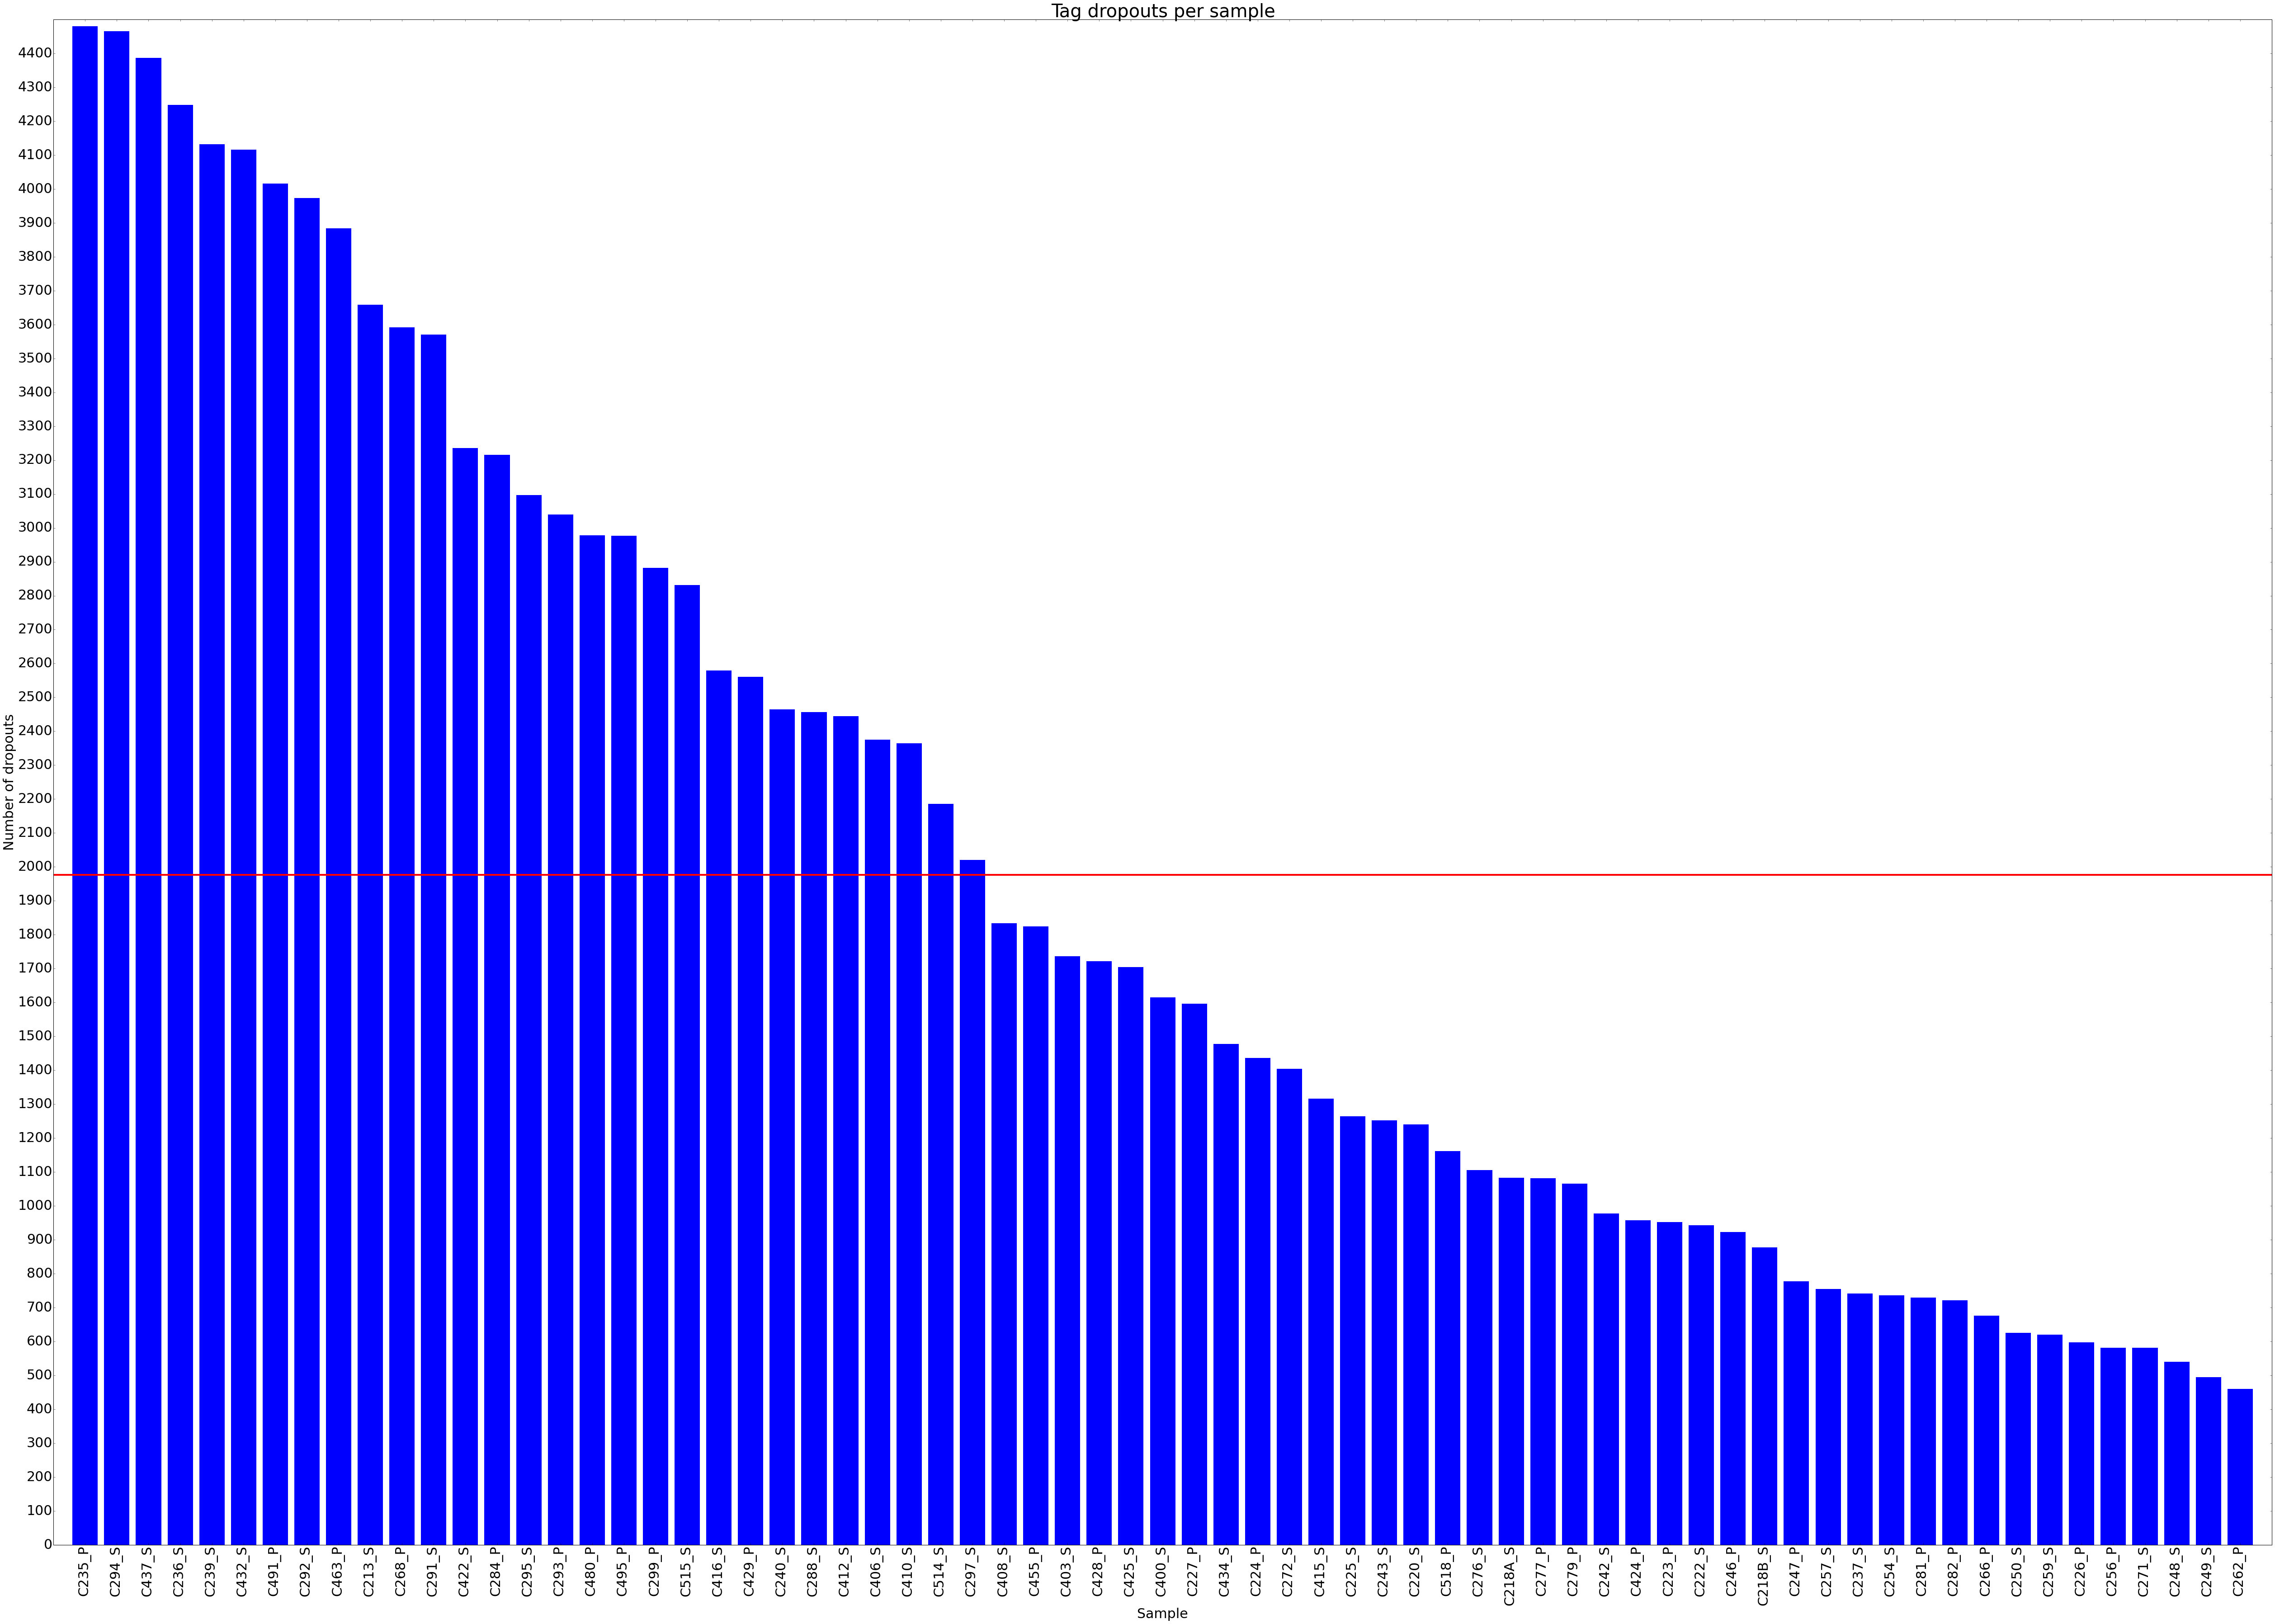

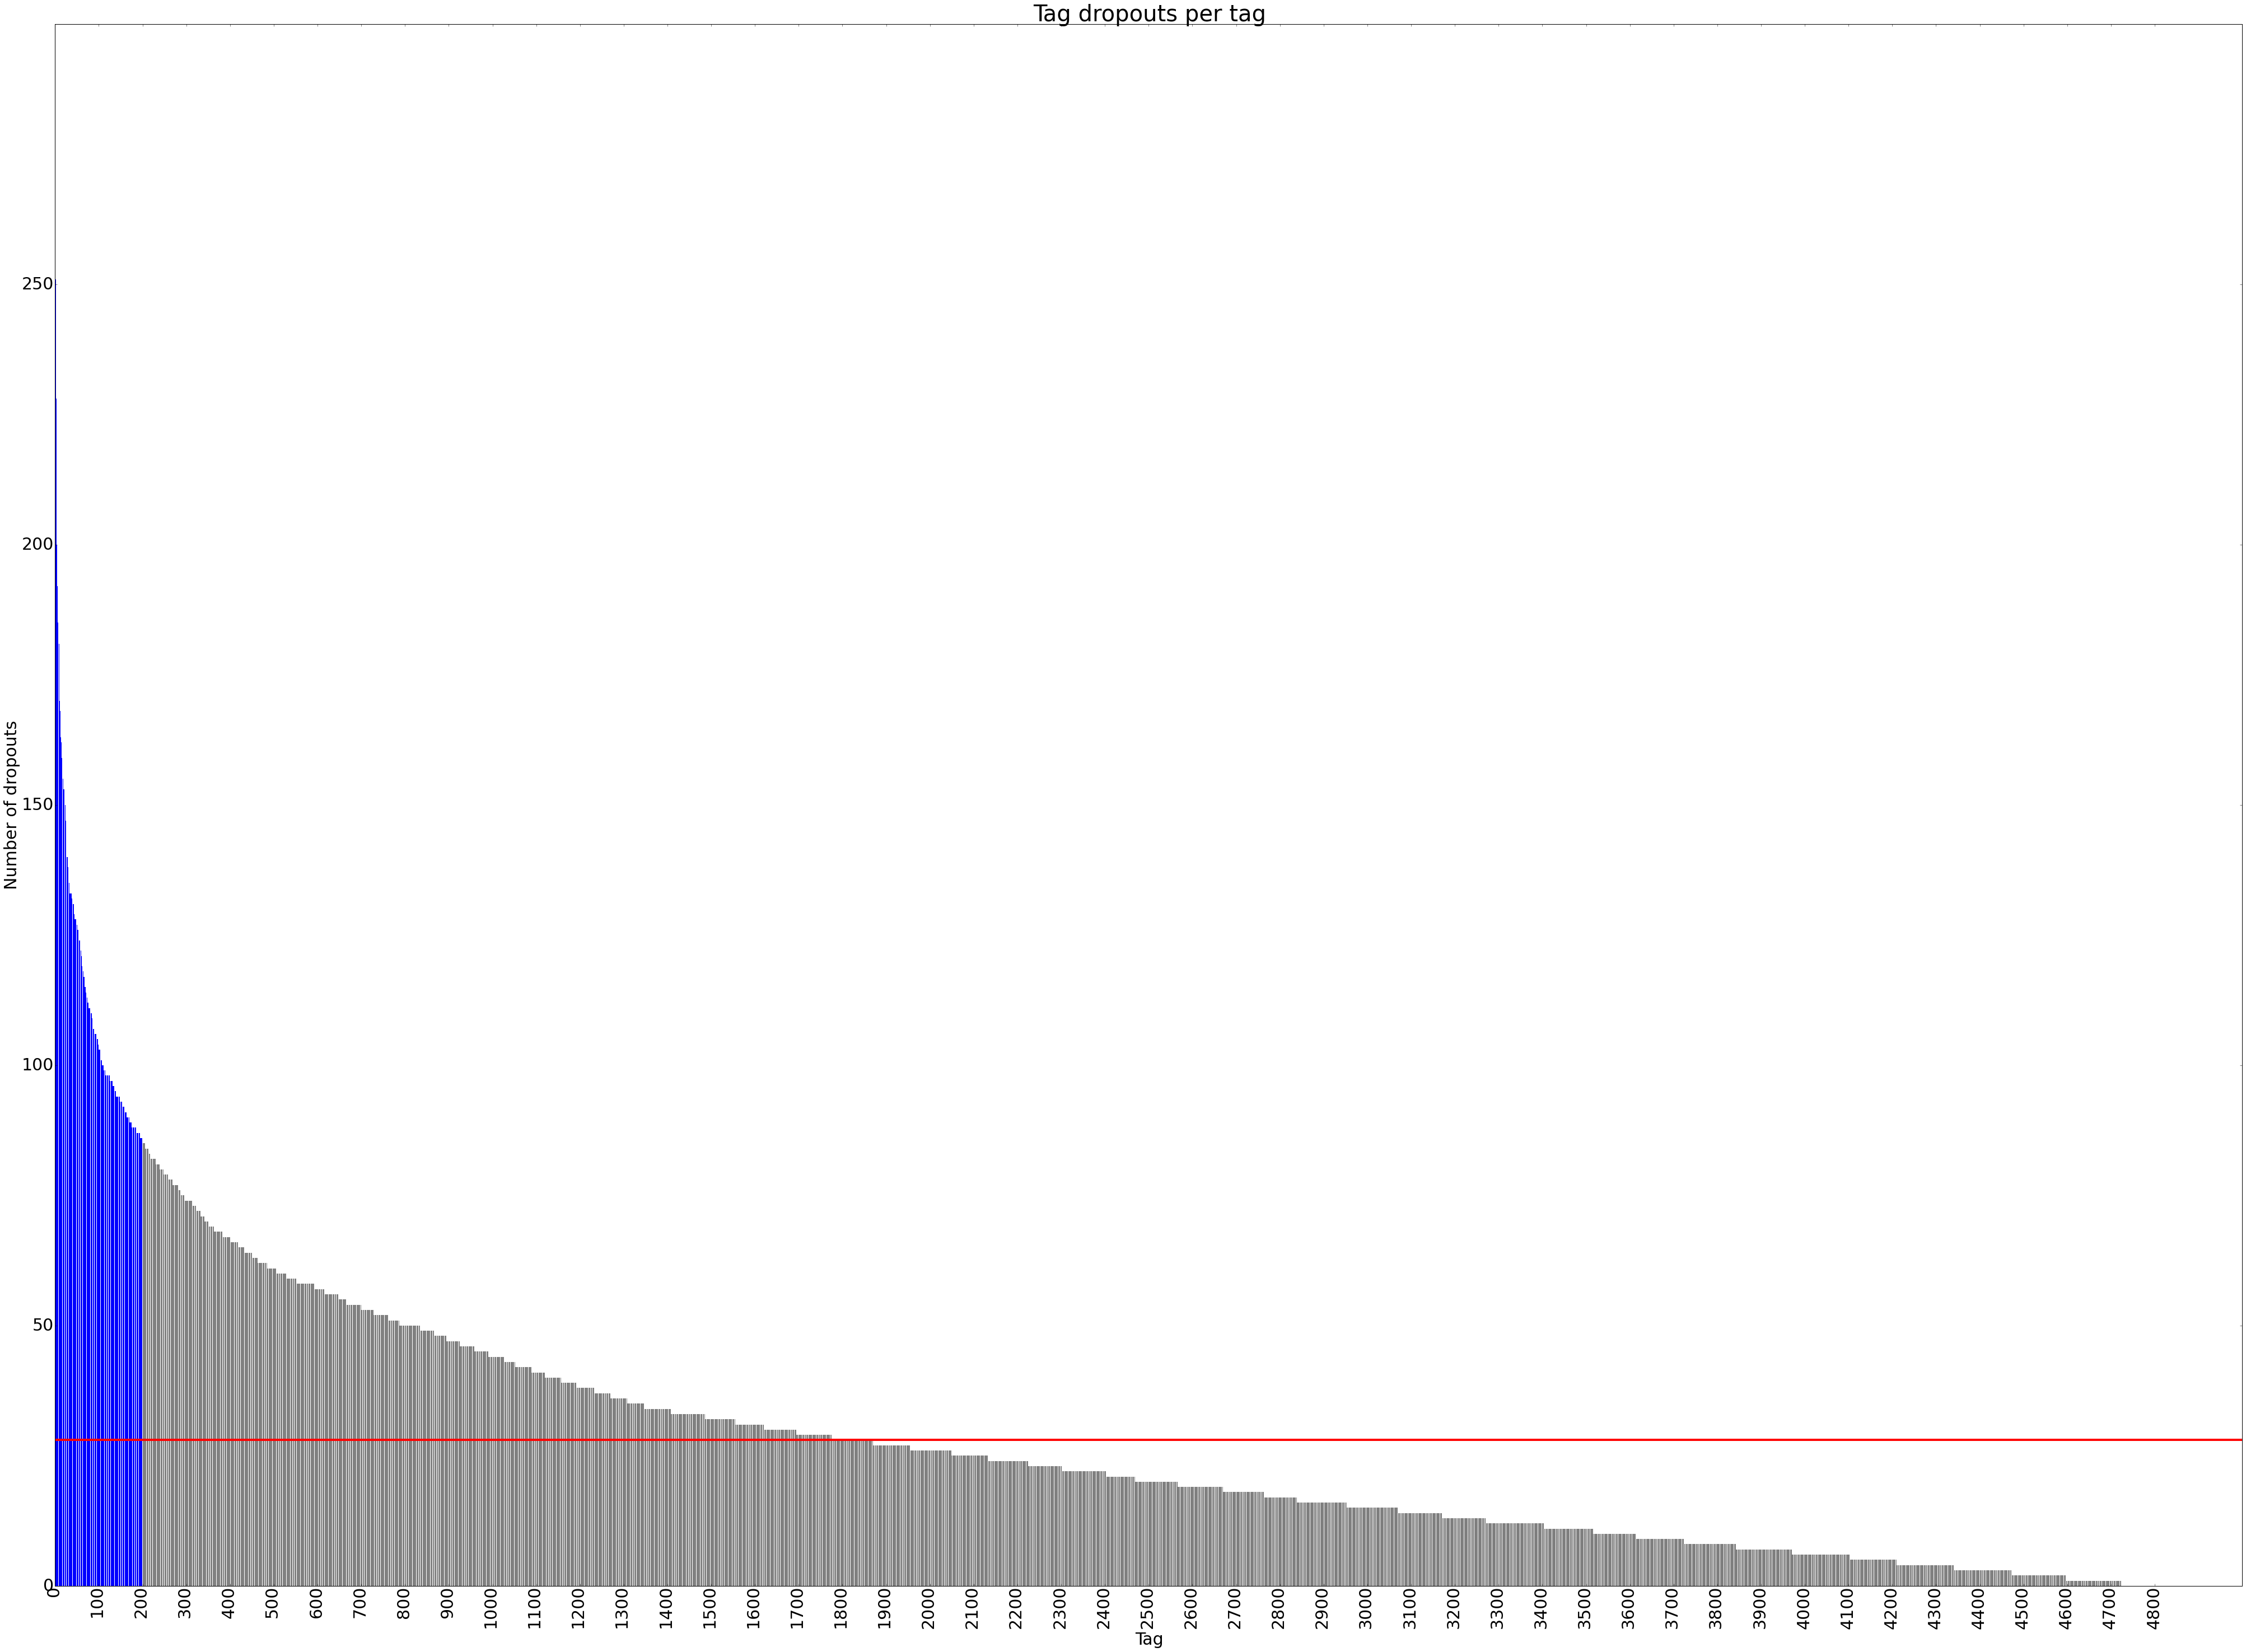

Outputs written to:
/home/djeffrie/Data/Caspers_data/populations/r_05_goodsamples//Tag_dropouts_per_sample.txt
/home/djeffrie/Data/Caspers_data/populations/r_05_goodsamples//Tag_dropouts_per_tag.txt
/home/djeffrie/Data/Caspers_data/populations/r_05_goodsamples//Tag_droupouts_per_sample.pdf
/home/djeffrie/Data/Caspers_data/populations/r_05_goodsamples//Tag_droupouts_per_tag.pdf
/home/djeffrie/Data/Caspers_data/populations/r_05_goodsamples//blacklist.txt


In [61]:
per_sample_dropouts = missing_data_finder('/home/djeffrie/Data/Caspers_data/populations/r_05_goodsamples/batch_1d.vcf', '/home/djeffrie/Data/Caspers_data/populations/r_05_goodsamples/', 200)

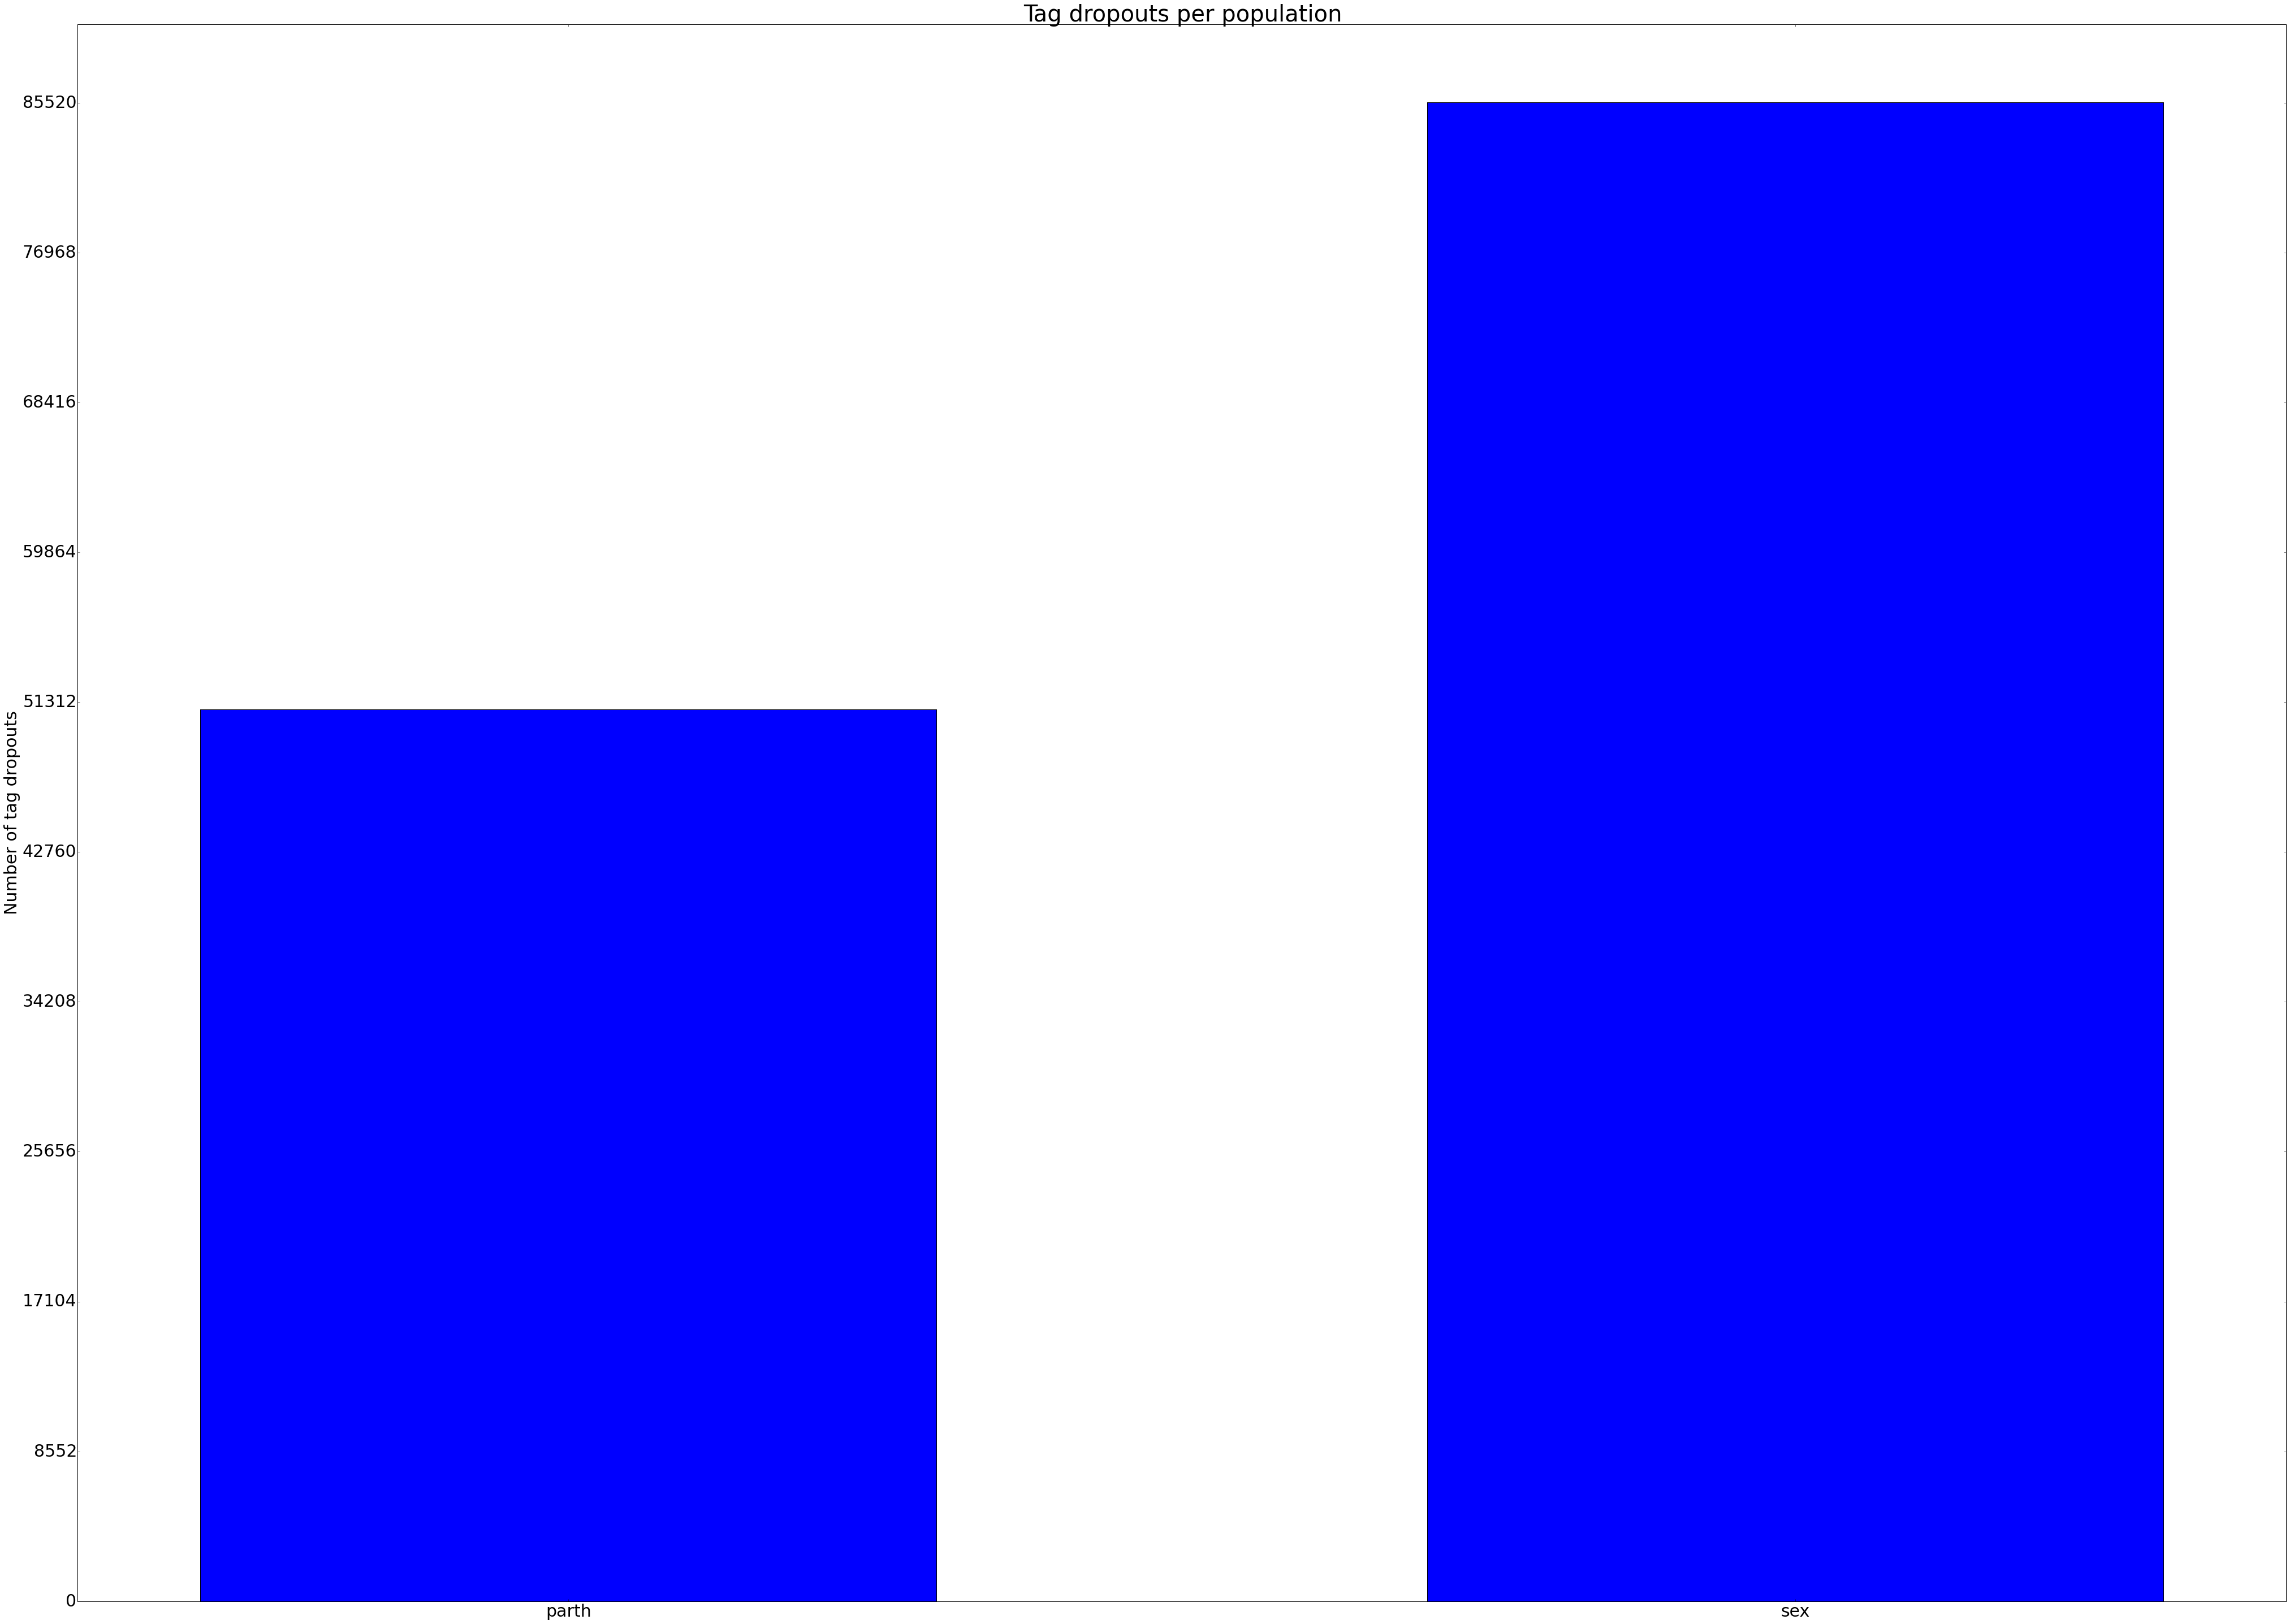

In [136]:
missing_data_per_pop(per_sample_dropouts, "/home/djeffrie/Data/Caspers_data/populations/r_05_allsamples/popmap.txt", "/home/djeffrie/Data/Caspers_data/populations/r_05_allsamples/")